# Análise da Inadimplência dos Clientes de Cartão de Crédito

<img src='./cartao.jpeg' width=450>

### Bibliotecas

In [ ]:
import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import math
import geopandas as gpd
import folium
from folium.plugins import HeatMap

import warnings
warnings.filterwarnings('ignore')

### Carregando a Base de Dados

In [ ]:
def processar_arquivos_zip(zip_content, tipo_cliente, colunas):
    bases = []
    with zipfile.ZipFile(io.BytesIO(zip_content)) as z:
        for mes in range(1, 13):
            file_name = f'planilha_2023{mes:02d}.csv'
            if file_name in z.namelist():
                with z.open(file_name) as file:
                    dados = pd.read_csv(file, sep=';')
                    dados = dados.iloc[:, colunas]
                    dados = dados[dados['cliente'] == tipo_cliente]
                    bases.append(dados)
    
    dataset = pd.concat(bases, axis=0)
    return dataset

In [ ]:
tipo_cliente = 'PF'
colunas = [0, 1, 2, 4, 5, 8, 9, 11, 12, 20, 21, 22]
url = "https://www.bcb.gov.br/pda/desig/planilha_2023.zip"

response = requests.get(url)
if response.status_code == 200:
    base = processar_arquivos_zip(response.content, tipo_cliente, colunas)
else:
    print("Erro ao fazer o download do arquivo.")

In [33]:
# Visualizando primeiras linhas da base de dados
base.head()

,data_base,uf,tcb,cliente,ocupacao,porte,modalidade,indexador,numero_de_operacoes,carteira_ativa,carteira_inadimplida_arrastada,ativo_problematico
0,2023-01-31,AC,Bancário,PF,PF - Aposentado/pensionista,PF - Mais de 1 a 2 salários mínimos,PF - Cartão de crédito,Prefixado,20,"11861,23","0,00","3508,25"
1,2023-01-31,AC,Bancário,PF,PF - Aposentado/pensionista,PF - Mais de 1 a 2 salários mínimos,PF - Empréstimo sem consignação em folha,Prefixado,<= 15,"1203,13","0,00","0,00"
2,2023-01-31,AC,Bancário,PF,PF - Autônomo,PF - Mais de 1 a 2 salários mínimos,PF - Cartão de crédito,Prefixado,<= 15,"3623,48","0,00","0,00"
3,2023-01-31,AC,Bancário,PF,PF - Empregado de empresa privada,PF - Mais de 1 a 2 salários mínimos,PF - Cartão de crédito,Prefixado,26,"17963,23","1496,98","3061,30"
4,2023-01-31,AC,Bancário,PF,PF - Empregado de empresa privada,PF - Mais de 2 a 3 salários mínimos,PF - Cartão de crédito,Prefixado,<= 15,"2855,66","2246,28","2855,66"


In [34]:
# Dimensões do base
f'linhas: {base.shape[0]}, colunas: {base.shape[1]}'

'linhas: 1674267, colunas: 12'

**Para a análise de individamento de pessoas físicas por cartão de crédito usaremos as seguintes variáveis**:

- **data_base**: Data da coleta dos dados;
- **uf**: Unidade federativa brasileira;
- **tcb**: Tipo de consolidado bancário;
- **ocupacao**: Natureza de ocupação das pessoas físicas;
- **porte**: Porte financeiro do cliente;
- **indexador**: Indexadores das operações;
- **carteira_ativa**: Soma dos valores a vencer e vencidos;
- **carteira_inadimplida_arrastada**: Soma das operações de crédito que estão vencidas há mais de 90 dias;
- **ativo_problematico**: São operações as quais existem indícios que não serão integralmente honradas.

### Tratamento da Base de dados

In [ ]:
# Verificando dados nulos
base.isnull().sum()

data_base                         0
uf                                0
tcb                               0
cliente                           0
ocupacao                          0
porte                             0
modalidade                        0
indexador                         0
numero_de_operacoes               0
carteira_ativa                    0
carteira_inadimplida_arrastada    0
ativo_problematico                0
dtype: int64

In [7]:
# Padronizando as datas
base['data_base'] = pd.to_datetime(base['data_base'], format='%Y-%m-%d').dt.date

In [8]:
# transformando os valores em float
def transformando_valores_float(valor):
    valor = re.sub(r'\s|,', '.', valor)
    return float(valor)

base['carteira_ativa'] = base['carteira_ativa'].apply(transformando_valores_float)
base['carteira_inadimplida_arrastada'] = base['carteira_inadimplida_arrastada'].apply(transformando_valores_float)
base['ativo_problematico'] = base['ativo_problematico'].apply(transformando_valores_float) 

In [9]:
# Limpando dados das variáveis
def limpar_porte_modalidade_ocupacao(valor):
    valor = valor.replace('PF - ', '').replace('Mais de ', '').replace(' salários mínimos', '').replace(' salário mínimo', '').replace('Sem rendimento', '0').replace('Até 1', '0 a 1').replace('Acima de 20', '> 20').strip()
    return valor

base['porte'] = base['porte'].apply(limpar_porte_modalidade_ocupacao)
base['modalidade'] = base['modalidade'].apply(limpar_porte_modalidade_ocupacao)
base['ocupacao'] = base['ocupacao'].apply(limpar_porte_modalidade_ocupacao)
base['numero_de_operacoes'] = base['numero_de_operacoes'].replace('<= ', '', regex=True).astype(int)

In [10]:
# Removendo Outliers
def remove_outliers(dados, variavel):
    q1 = dados[variavel].quantile(0.25)
    q3 = dados[variavel].quantile(0.75)

    iqr = q3 - q1

    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    dataset = dados[(dados[variavel] >= limite_inferior) & (dados[variavel] <= limite_superior)]

    return dataset


base = remove_outliers(base, 'numero_de_operacoes')
base = remove_outliers(base, 'carteira_ativa')
base = remove_outliers(base, 'carteira_inadimplida_arrastada')
base = remove_outliers(base, 'ativo_problematico')

In [12]:
# Agrupando as UFs por região
norte = ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO']
nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
centro_oeste = ['DF', 'GO', 'MS', 'MT']
sudeste = ['ES', 'RJ', 'MG', 'SP']
sul = ['PR', 'RS', 'SC']

# Criando coluna de regiões
base.loc[base['uf'].isin(norte), 'regiao'] = 'norte'
base.loc[base['uf'].isin(nordeste), 'regiao'] = 'nordeste'
base.loc[base['uf'].isin(centro_oeste), 'regiao'] = 'centro oeste'
base.loc[base['uf'].isin(sudeste), 'regiao'] = 'sudeste'
base.loc[base['uf'].isin(sul), 'regiao'] = 'sul'

In [13]:
# Alterando título das colunas
base = base.rename(columns={
    'data_base':'data',
    'carteira_ativa':'carteira_total',
    'carteira_inadimplida_arrastada':'carteira_inadimplencia'
})

In [14]:
# Filtrando os dados importantes
base = base[base['modalidade'] == 'Cartão de crédito']
base = base[base['ocupacao'] != 'Outros']
base = base[base['porte'] != 'Indisponível']

In [15]:
# Visualizando base após tratamento
base.head()

,data,uf,tcb,cliente,ocupacao,porte,modalidade,indexador,numero_de_operacoes,carteira_total,carteira_inadimplencia,ativo_problematico,regiao
0,2023-01-31,AC,Bancário,PF,Aposentado/pensionista,1 a 2,Cartão de crédito,Prefixado,20,11861.23,0.00,3508.25,norte
2,2023-01-31,AC,Bancário,PF,Autônomo,1 a 2,Cartão de crédito,Prefixado,15,3623.48,0.00,0.00,norte
3,2023-01-31,AC,Bancário,PF,Empregado de empresa privada,1 a 2,Cartão de crédito,Prefixado,26,17963.23,1496.98,3061.30,norte
4,2023-01-31,AC,Bancário,PF,Empregado de empresa privada,2 a 3,Cartão de crédito,Prefixado,15,2855.66,2246.28,2855.66,norte
5,2023-01-31,AC,Bancário,PF,Empregado de empresa privada,3 a 5,Cartão de crédito,Prefixado,15,174.80,0.00,0.00,norte


In [16]:
# Dimensões da base de dados tratada
print(f'Total de Linhas: {base.shape[0]}, Total de Colunas: {base.shape[1]}')

Total de Linhas: 81548, Total de Colunas: 13


In [17]:
# Salvando base
base.to_csv('base_consolidada_pf.csv', index=False)

### Análise Exploratória

In [18]:
# Carregando a base consolidada
df = pd.read_csv('base_consolidada_pf.csv')

# Visualizando primeiras linhas
df.head()

,data,uf,tcb,cliente,ocupacao,porte,modalidade,indexador,numero_de_operacoes,carteira_total,carteira_inadimplencia,ativo_problematico,regiao
0,2023-01-31,AC,Bancário,PF,Aposentado/pensionista,1 a 2,Cartão de crédito,Prefixado,20,11861.23,0.00,3508.25,norte
1,2023-01-31,AC,Bancário,PF,Autônomo,1 a 2,Cartão de crédito,Prefixado,15,3623.48,0.00,0.00,norte
2,2023-01-31,AC,Bancário,PF,Empregado de empresa privada,1 a 2,Cartão de crédito,Prefixado,26,17963.23,1496.98,3061.30,norte
3,2023-01-31,AC,Bancário,PF,Empregado de empresa privada,2 a 3,Cartão de crédito,Prefixado,15,2855.66,2246.28,2855.66,norte
4,2023-01-31,AC,Bancário,PF,Empregado de empresa privada,3 a 5,Cartão de crédito,Prefixado,15,174.80,0.00,0.00,norte


In [19]:
# Estatísticas descritivas
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

,numero_de_operacoes,carteira_total,carteira_inadimplencia,ativo_problematico
count,81548.00,81548.00,81548.00,81548.00
mean,54.65,97750.25,2022.39,2983.27
std,86.87,226225.28,3961.63,4946.30
min,15.00,1.04,0.00,0.00
25%,15.00,5163.66,0.00,0.00
50%,15.00,21274.72,0.00,0.00
75%,49.00,84150.94,1978.65,4216.19
max,602.00,2451203.87,19877.46,19882.68


In [20]:
df['tcb'].value_counts()

tcb
Não bancário    33669
Bancário        32357
Cooperativas    15522
Name: count, dtype: int64

In [21]:
df['ocupacao'].value_counts()

ocupacao
Empregado de entidades sem fins lucrativos    14372
Aposentado/pensionista                        12494
MEI                                           12002
Autônomo                                      11158
Servidor ou empregado público                 11045
Empregado de empresa privada                  10366
Empresário                                    10111
Name: count, dtype: int64

In [22]:
df['porte'].value_counts()

porte
0 a 1      11729
1 a 2      11048
> 20       10762
2 a 3      10696
3 a 5      10059
10 a 20     9827
5 a 10      9359
0           8068
Name: count, dtype: int64

In [23]:
df['indexador'].value_counts()

indexador
Prefixado             56587
Outros indexadores    16573
Índices de preços      4931
Pós-fixado             3257
Flutuantes              200
Name: count, dtype: int64

## Análise

### 1. Análise de Endividamento e Inadimplência

Para entender melhor a relação entre os valores da carteira total e a inadimplência, podemos calcular a razão entre a inadimplência e a carteira total. Isso ajudará a identificar segmentos mais arriscados e com maior potencial de inadimplência.

In [24]:
# Calculando a taxa de inadimplência
df['taxa_inadimplencia'] = df['carteira_inadimplencia']  / df['carteira_total'] * 100

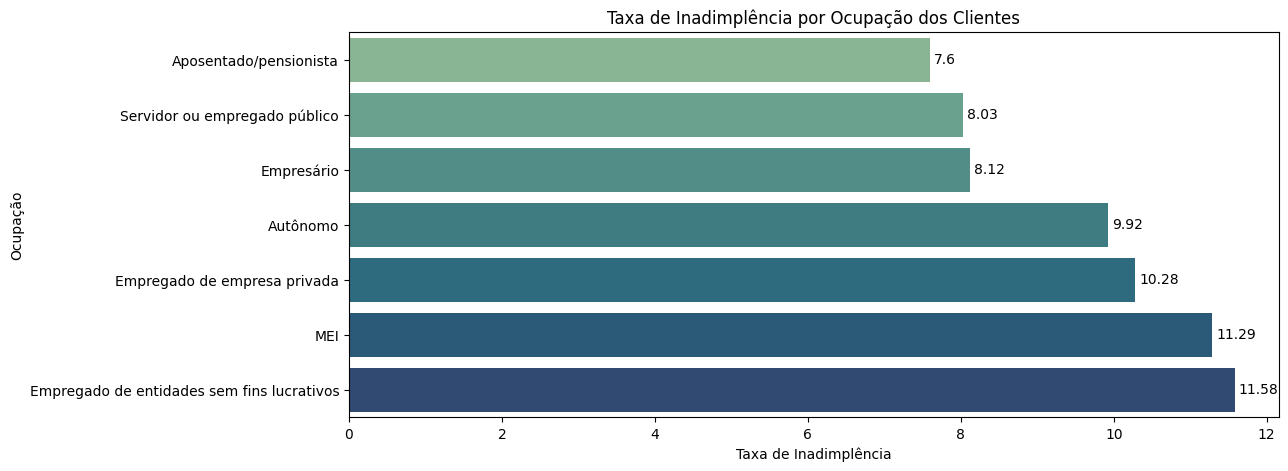

In [25]:
ocupacao = round(df.groupby('ocupacao')['taxa_inadimplencia'].mean().reset_index().sort_values(by='taxa_inadimplencia'),2)

plt.figure(figsize=(12,5))
ax = sns.barplot(x='taxa_inadimplencia', y='ocupacao', data=ocupacao, palette='crest')
for container in ax.containers:
    ax.bar_label(container, fontsize=10, padding=3, color='black')
plt.ylabel('Ocupação')
plt.xlabel('Taxa de Inadimplência')
plt.title('Taxa de Inadimplência por Ocupação dos Clientes')
plt.show()

**Insights de Inadimplência**

- Clientes com ocupação "Aposentado/Pensionista", "Servidor ou empregado público" e "Empresário" apresentão uma média de taxas de endividamento abaixo de 10%, indicando que clientes destas ocupações tendem a ter mais estabilidade financeira.

- Já as demais ocupações apresentam taxas de inadimplência superiores a 11%, destaque para o "MEI" que apresenta a maior taxa média de 11.8%, isso pode ser um sinal de vunerabilidade, pois indica que muitos desses clientes podem não ter fontes de renda regulares.

### 2. Análise de Ativos Problemáticos

Ativos problemáticos são aqueles que estão na carteira de inadimplência ou com valores problemáticos. Analisando essa dimensão podemos entender quais segmentos de clientes têm mais risco associado.

In [26]:
# Calculando ativos problemáticos
df['total_ativos_problematicos'] = df['carteira_inadimplencia'] + df['ativo_problematico']

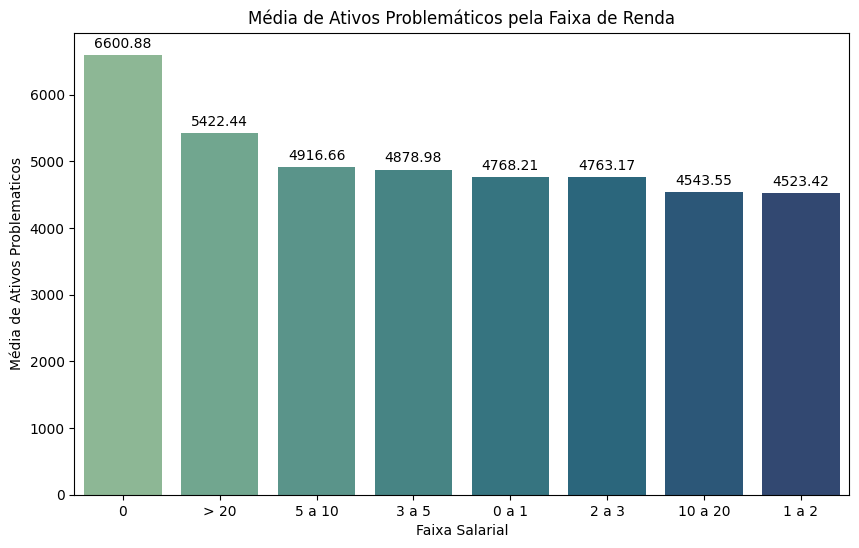

In [27]:
porte = df.groupby('porte')['total_ativos_problematicos'].mean().reset_index().sort_values(by='total_ativos_problematicos', ascending=False)

plt.figure(figsize=(10,6))
ax = sns.barplot(x='porte', y='total_ativos_problematicos', data=porte, palette='crest')
for container in ax.containers:
    ax.bar_label(container, fontsize=10, padding=3, color='black')
plt.ylabel('Média de Ativos Problematicos')
plt.xlabel('Faixa Salarial')
plt.title('Média de Ativos Problemáticos pela Faixa de Renda')
plt.show()

**Insights sobre Ativos Problemáticos**

- Podemos observar que clientes sem renda e com renda acima de 20 salários mínimos, apresentaram as maiores médias de ativos problématicos, isso indica que esses clientes podem esta passando por dificuldades financeiras.

- As demais faixas de renda se mantem com media de ativos problemáticos entre 4.000 e 4.900.

### 3. Impacto da Região e Indexador na Inadimplência
A região e o indexador podem ter influência importante nas taxas de inadimplência. Vamos verificar como esses fatores impactam a taxa de inadimplência.

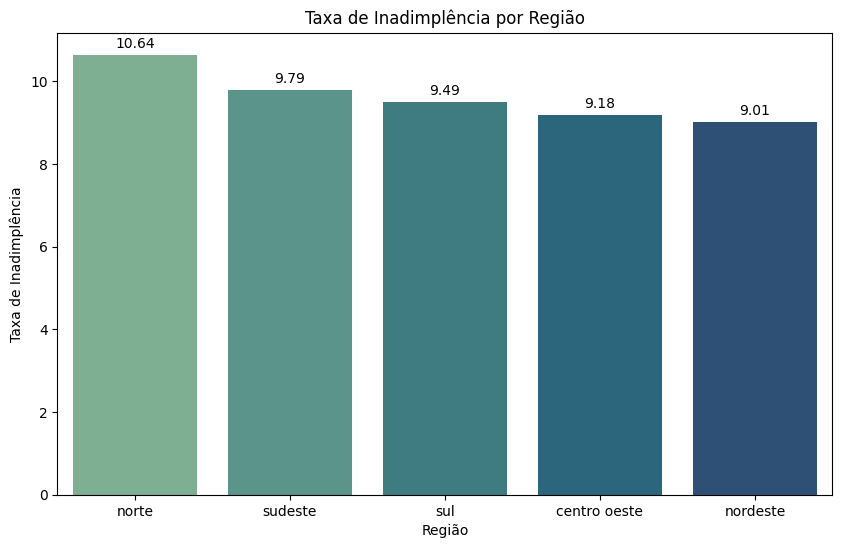

In [28]:
# Taxa de inadimplência por região
regiao_inadimplencia = round(df.groupby('regiao')['taxa_inadimplencia'].mean().sort_values(ascending=False).reset_index(), 2)

plt.figure(figsize=(10,6))
ax = sns.barplot(x='regiao', y='taxa_inadimplencia', data=regiao_inadimplencia, palette='crest')
for container in ax.containers:
    ax.bar_label(container, fontsize=10, padding=3, color='black')
plt.ylabel('Taxa de Inadimplência')
plt.xlabel('Região')
plt.title('Taxa de Inadimplência por Região')
plt.show()


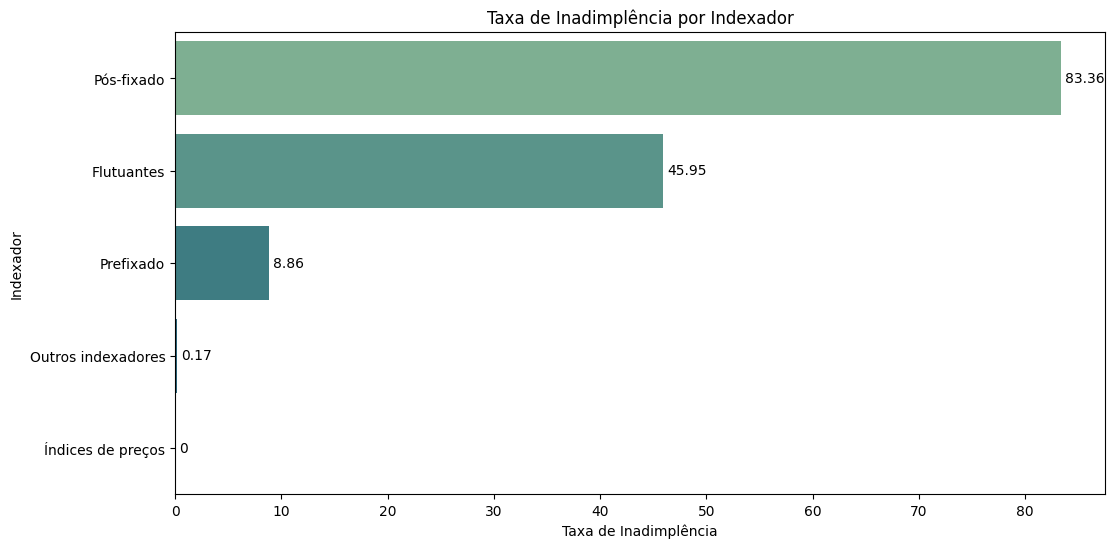

In [30]:
# Taxa de inadimplência por indexador
indexador_inadimplencia = round(df.groupby('indexador')['taxa_inadimplencia'].mean().sort_values(ascending=False).reset_index(), 2)

# Visualizando os resultados
plt.figure(figsize=(12,6))
ax = sns.barplot(x='taxa_inadimplencia', y='indexador', data=indexador_inadimplencia, palette='crest')
for container in ax.containers:
    ax.bar_label(container, fontsize=10, padding=3, color='black')
plt.xlabel('Taxa de Inadimplência')
plt.ylabel('Indexador')
plt.title('Taxa de Inadimplência por Indexador')
plt.show()

**Insights sobre Região e Indexador**

- Região Norte e Sudeste apresenta uma taxa de inadimplência superior em comparação a outras regiões, sugerindo que a empresa deve ser cautelosa ao lançar seu produto nesta localidade.

- Clientes com indexadores "Pós-fixado" e "Flutuantes" apresentam taxas de inadimplência mais altas, o que pode ser um reflexo de condições de crédito menos flexíveis e resultado da atual economia.

### 4. Regiões com Maior Uso de Cartão de Crédito


In [31]:
# Supondo que você já tenha o DataFrame 'df' com as taxas de inadimplência por região
inadimplencia_por_regiao = df.groupby('regiao')['numero_de_operacoes'].sum().reset_index()

# Carregar o arquivo shapefile (verifique se o caminho está correto)
gdf_uf = gpd.read_file('BR_Microrregioes_2022.shp')

# Verifique se a coluna 'regiao' existe no gdf_uf, se não, troque por uma coluna correspondente
gdf_uf = gdf_uf.merge(inadimplencia_por_regiao, left_on='geometry', right_on='numero_de_operacoes', how='left')

# Criar o mapa com Folium
m = folium.Map(location=[-14.2350, -51.9253], max_zoom=4, min_zoom=4, control_scale=True)

# Preparando os dados para o HeatMap
heat_data = [[row['geometry'].centroid.y, row['geometry'].centroid.x, row['numero_de_operacoes']] 
             for idx, row in gdf_uf.iterrows()]

# Remover valores NaN nas taxas de inadimplência
heat_data = [sublist[:-1] if math.isnan(sublist[-1]) else sublist for sublist in heat_data]

# Adicionar o HeatMap ao mapa
HeatMap(heat_data, radius=9, blur=10).add_to(m)

# Exibir o mapa
m


**Insights de Regiões que Mais Usam**

- Se a empresa planeja lançar um cartão de crédito, pode ser útil direcionar campanhas promocionais para as regiões Nordeste, Suldeste e Sul,pois são regiões com uso elevado de cartão de crédito, onde a demanda pode ser mais alta, mas manter o controle da inadimplência nessas regiões.

## Conclusões e Recomendação

Com base na análise dos dados, podemos concluir que:

1. **O segmento de Aposentados/Pensionistas** é um dos menos arriscados devido ao perfil de endividamento e inadimplência. A empresa pode considerar oferecer condições diferenciadas ou taxas de juros mais baixas para este público.

2. **Autônomos, MEI e Empregados de empresas sem fins lucrativos** representam riscos elevados, principalmente em faixas de endividamento de 1 a 5 anos. A empresa pode precisar avaliar a viabilidade de crédito com mais rigor para esses clientes.

3. **A região Norte apresenta maiores taxas de inadimplência** e, portanto, pode ser necessário desenvolver estratégias específicas para mitigar o risco na região, como limites de crédito mais baixos ou taxas de juros mais altas.

4. **O indexador também é um fator relevante**. Para produtos com indexador pós-fixado ou flutuantes, é importante entender a relação entre as condições do mercado e o comportamento dos clientes para ajustar os riscos de inadimplência.

5. **Para o lançamento de um cartão de crédito** deve-se ter cautela e buscar reduzir riscos de inadimplência, é importante avaliar como as políticas de crédito podem ser ajustadas de acordo com os padrões de uso e inadimplência regionais.

A empresa deve focar no desenvolvimento de estratégias de crédito mais personalizadas, levando em consideração as particularidades de ocupação, região e indexador para minimizar os riscos de inadimplência e maximizar a rentabilidade do produto.



# Fim